In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
import xesmf as xe
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import scipy
import scipy.stats
import gsw
from defs import smm, mask, maskzonmean

In [2]:
folder = 'Data_processed/'
modellist =  ['CCSM4-UoT', 'CESM2', 'IPSL-CM5A2', 'MIROC4m', 'COSMOS', 'HadCM3', 'NorESM1-F']

In [3]:
dsgrid = xr.open_dataset(folder+'1x1grid.nc')
area = dsgrid.area 

#Open and calculate MMM sea-ice cover
dsE280 = xr.open_dataset(folder+'SMM_ensemble/E280/SI_100yr.nc')
dsE400 = xr.open_dataset(folder+'SMM_ensemble/E400/SI_100yr.nc')
dsEoi400 = xr.open_dataset(folder+'SMM_ensemble/Eoi400/SI_100yr.nc')

siE280 = smm(dsE280.si_mean)
siE400 = smm(dsE400.si_mean)
siEoi400 = smm(dsEoi400.si_mean)

#Open density datasets and calculate zonal mean density for each model
dsE280rho, dsE400rho, dsEoi400rho = xr.open_dataset(folder+'SMM_ensemble/E280/rho_1x1_100yr.nc'), xr.open_dataset(folder+'SMM_ensemble/E400/rho_1x1_100yr.nc'), xr.open_dataset(folder+'SMM_ensemble/Eoi400/rho_1x1_100yr.nc')
zmE280, zmE400, zmEoi400 = (dsE280rho.rho.mean(dim='lon')), (dsE400rho.rho.mean(dim='lon')), (dsEoi400rho.rho.mean(dim='lon'))

#Open stratification index datasets
dsE280si, dsE400si, dsEoi400si = xr.open_dataset(folder+'SMM_ensemble/E280/stratindex_1x1_100yr.nc'), xr.open_dataset(folder+'SMM_ensemble/E400/stratindex_1x1_100yr.nc'), xr.open_dataset(folder+'SMM_ensemble/Eoi400/stratindex_1x1_100yr.nc')

In [4]:
lat=dsE280rho.lat
z = dsE280rho.z

coords = xr.Dataset(data_vars = dict(z2D=(["z", "lat"], np.repeat(z.values[:, np.newaxis]/1000, len(lat), axis=1))), coords = dict(z = z.values/1000, lat = lat.values))
coords['lat2D'] = coords.z2D.copy(deep=True)
coords.lat2D[:] = np.transpose(np.repeat(lat.values[:, np.newaxis], len(z), axis=1))

mask1 = maskzonmean(zmE280, zmE400, smm(zmE280), 5)
mask2 = maskzonmean(zmE400, zmEoi400, smm(zmE400), 5)
mask3 = maskzonmean(zmE280, zmEoi400, smm(zmEoi400), 5)

In [5]:
def siedge(si):
    zm = si.mean(dim='lon')
    edge = zm.where(zm.lat<0,drop=True).where(zm>=15, drop=True).lat.max()
    return (edge.values)

In [6]:
coords2, mask4 = mask(dsE400si.rho, dsE280si.rho, smm(dsE280si.rho), 5)
coords2, mask5 = mask(dsEoi400si.rho, dsE400si.rho, smm(dsE400si.rho), 5)
coords2, mask6 = mask(dsEoi400si.rho, dsE280si.rho,  smm(dsEoi400si.rho), 5)

/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_62375/3041967921.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap("cmo.curl",10).copy()


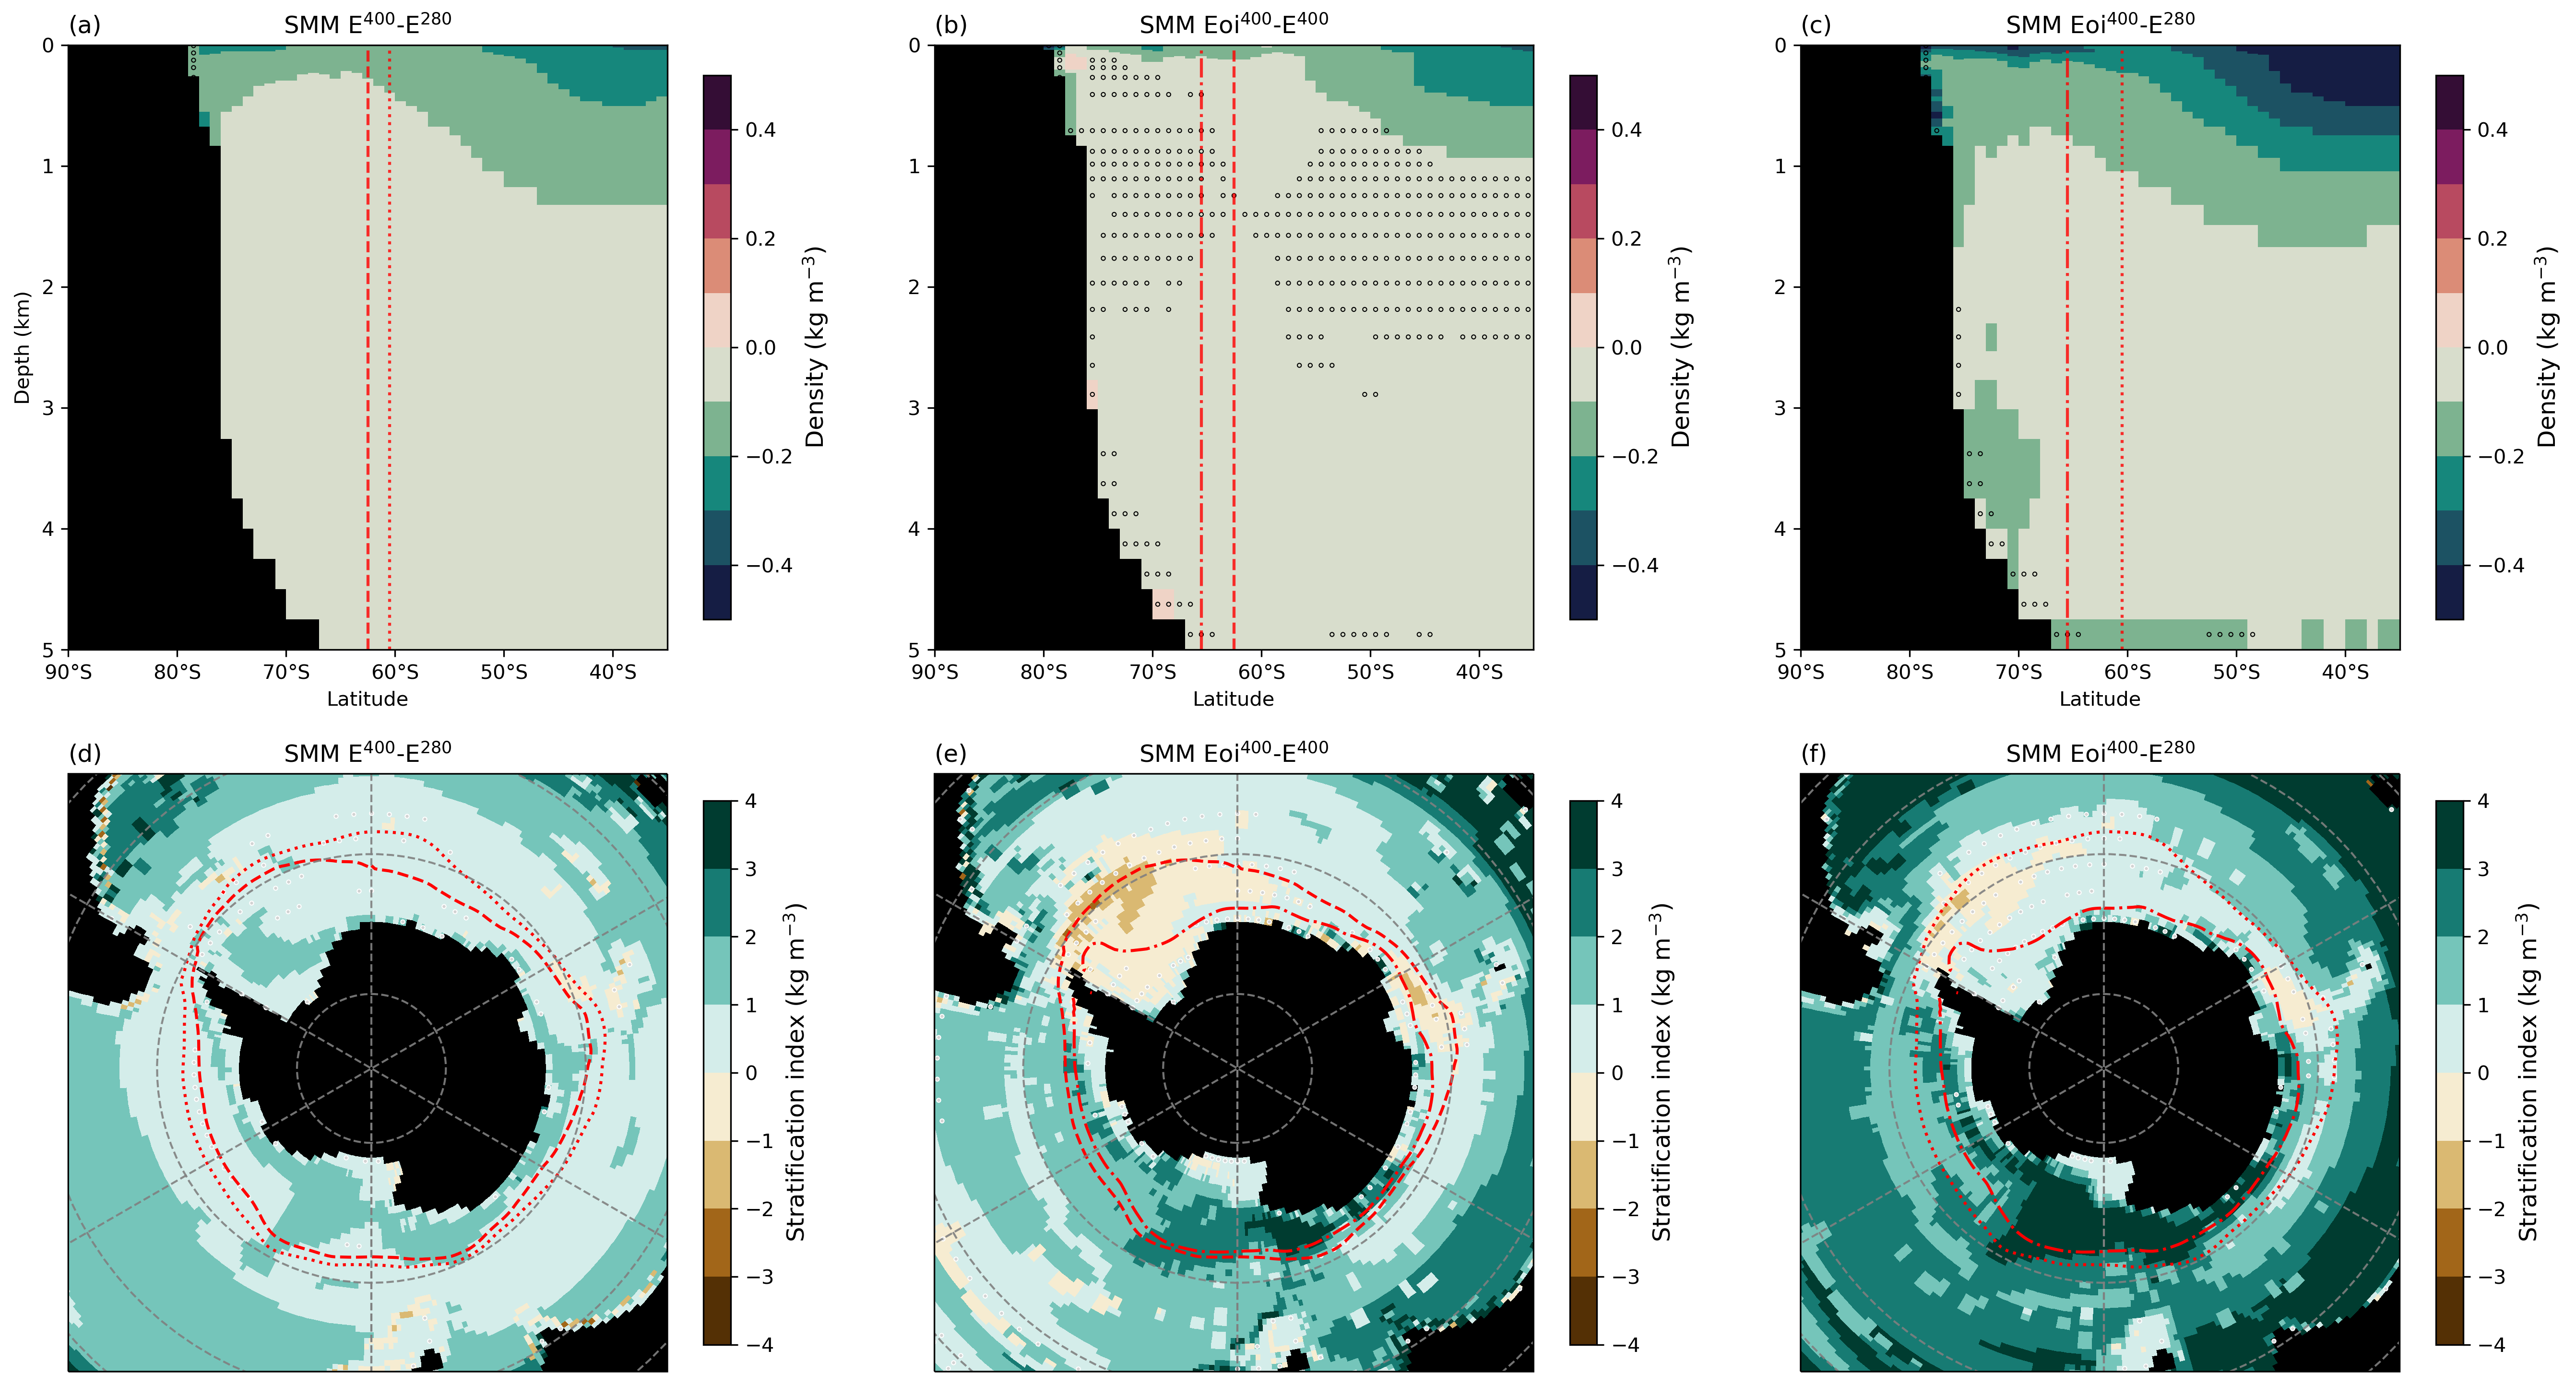

In [7]:
x_pos = np.array([-90,-80,-70,-60,-50,-40])
xtext = ('90$\degree$S', '80$\degree$S', '70$\degree$S', '60$\degree$S', '50$\degree$S', '40$\degree$S')

## creeer je figuur:
fig = plt.figure(figsize=(22,12), dpi=300)
## creeer je assen. Ik voeg hier de projectie 'plate carree' toe, Cartopy heeft verschillende, bijv EqualEarth
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

cmap2 = plt.cm.get_cmap("cmo.curl",10).copy()
cmap2.set_bad('black')
divnorm = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)

anom1 = smm(zmEoi400-zmE280)
anom2 = smm(zmE400-zmE280)
anom3 = smm(zmEoi400-zmE400)

ax = fig.add_subplot(231)
im = ax.pcolormesh(dsEoi400rho.lat, dsEoi400rho.z/1000, (anom2), cmap=cmap2, norm=divnorm)
ax.scatter(coords.lat2D.where(mask1==0).sel(z=slice(0,0.8))[::6], coords.z.where(mask1==0).sel(z=slice(0,0.8))[::6], s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Density (kg m$^{-3}$)', fontsize=12)
ax.set_title('SMM E$^{400}$-E$^{280}$', loc='center')
ax.set_title('(a)', loc='left')
ax.set_xlabel('Latitude')
ax.axvline(siedge(siE400), linestyle='dashed', color='r',alpha=0.8)
ax.axvline(siedge(siE280), linestyle='dotted', color='r', alpha=0.8)
ax.set_ylabel('Depth (km)')
ax.set_ylim([0,5])
ax.set_xlim([-90,-35])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticks(x_pos)
ax.set_xticklabels(xtext)

ax = fig.add_subplot(232)
im=ax.pcolormesh(dsEoi400rho.lat, dsEoi400rho.z/1000, (anom3), cmap=cmap2, norm=divnorm)
ax.scatter(coords.lat2D.where(mask2==0).sel(z=slice(0.8,5.5)), coords.z.where(mask2==0).sel(z=slice(0.8,5.5)), s=4, facecolors='none', edgecolors='black', linewidth=0.5)
ax.scatter(coords.lat2D.where(mask2==0).sel(z=slice(0,0.8))[::6], coords.z.where(mask2==0).sel(z=slice(0,0.8))[::6], s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Density (kg m$^{-3}$)', fontsize=12)
ax.set_title('SMM Eoi$^{400}$-E$^{400}$', loc='center')
ax.set_title('(b)', loc='left')
ax.axvline(siedge(siEoi400), linestyle='dashdot', color='r',alpha=0.8)
ax.axvline(siedge(siE400), linestyle='dashed', color='r', alpha=0.8)
ax.set_xlabel('Latitude')
#ax.set_ylabel('Depth (km)')
ax.set_ylim([0,5])
ax.set_xlim([-90,-35])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticks(x_pos)
ax.set_xticklabels(xtext)

ax = fig.add_subplot(233)
im=ax.pcolormesh(dsEoi400rho.lat, dsEoi400rho.z/1000, (anom1), cmap=cmap2, norm=divnorm)
ax.scatter(coords.lat2D.where(mask3==0).sel(z=slice(0.8,5.5)), coords.z.where(mask3==0).sel(z=slice(0.8,5.5)), s=4, facecolors='none', edgecolors='black', linewidth=0.5)
ax.scatter(coords.lat2D.where(mask3==0).sel(z=slice(0,0.8))[::6], coords.z.where(mask3==0).sel(z=slice(0,0.8))[::6], s=4, facecolors='none', edgecolors='black', linewidth=0.5)
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Density (kg m$^{-3}$)', fontsize=12)
ax.set_title('SMM Eoi$^{400}$-E$^{280}$', loc='center')
ax.set_title('(c)', loc='left')
ax.axvline(siedge(siEoi400), linestyle='dashdot', color='r',alpha=0.8)
ax.axvline(siedge(siE280), linestyle='dotted', color='r', alpha=0.8)
ax.set_xlabel('Latitude')
ax.set_ylim([0,5])
ax.set_xlim([-90,-35])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticks(x_pos)
ax.set_xticklabels(xtext)

anom1 = smm(dsEoi400si.rho-dsE280si.rho)
anom2 = smm(dsE400si.rho-dsE280si.rho)
anom3 = smm(dsEoi400si.rho-dsE400si.rho)

# cmap2 = plt.cm.get_cmap("cmo.haline",10).copy()
# cmap2.set_bad('black')
cmap2 = plt.get_cmap('BrBG', 8)
cmap2.set_bad('black')
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

iceline = 15

ax = fig.add_subplot(234, projection=proj)
im=ax.pcolormesh(dsE280si.lon,dsE280si.lat,anom2, transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -4, vmax = 4)
cs1 = ax.scatter(coords2.lon2D.where(mask4==0).where(anom2.fillna(-200)!=-200)[::4,::4], coords2.lat2D.where(mask4==0).where(anom2.fillna(-200)!=-200)[::4,::4], s=4,
                 facecolors='lightgrey', edgecolors='white', linewidth=0.5, transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE400, colors=['red','red'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280, colors=['red','red'], linestyles = ['dotted'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-45], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Stratification index (kg m$^{-3}$)', fontsize=12)
ax.set_title('SMM E$^{400}$-E$^{280}$', loc='center')
ax.set_title(r'(d)', loc='left')
lat_lines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.9, linestyle='--')

ax = fig.add_subplot(235, projection=proj)
im=ax.pcolormesh(dsE280si.lon,dsE280si.lat,anom3, transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -4, vmax = 4)
cs1 = ax.scatter(coords2.lon2D.where(mask5==0).where(anom2.fillna(-200)!=-200)[::4,::4], coords2.lat2D.where(mask5==0).where(anom2.fillna(-200)!=-200)[::4,::4], s=4,
                 facecolors='lightgrey', edgecolors='white', linewidth=0.5, transform=ccrs.PlateCarree())
ax.contour(siE400.lon,siE280.lat,siEoi400, colors=['red','red'], linestyles = ['dashdot'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE400, colors=['red','red'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-45], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Stratification index (kg m$^{-3}$)', fontsize=12)
ax.set_title('SMM Eoi$^{400}$-E$^{400}$', loc='center')
ax.set_title(r'(e)', loc='left')
lat_lines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.9, linestyle='--')

ax = fig.add_subplot(236, projection=proj)
im=ax.pcolormesh(dsE280si.lon,dsE280si.lat,anom1, transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -4, vmax = 4)
cs1 = ax.scatter(coords2.lon2D.where(mask6==0).where(anom2.fillna(-200)!=-200)[::4,::4], coords2.lat2D.where(mask6==0).where(anom2.fillna(-200)!=-200)[::4,::4], s=4,
                 facecolors='lightgrey', edgecolors='white', linewidth=0.5, transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siEoi400, colors=['red','red'], linestyles = ['dashdot'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280, colors=['red','red'], linestyles = ['dotted'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-45], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'Stratification index (kg m$^{-3}$)', fontsize=12)
ax.set_title('SMM Eoi$^{400}$-E$^{280}$', loc='center')
ax.set_title(r'(f)', loc='left')
lat_lines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.9, linestyle='--')

#plt.savefig('Fig9.png', bbox_inches='tight')
plt.show()

In [8]:
## Stratification index for 45-60S and 60-90S, for individual model values see Table 1

In [9]:
#45-60S
siE280 = np.round(dsE280si.rho.where(dsE280si.lat<=-45).where(dsE280si.lat>=-60).weighted(area).mean(dim=['lat','lon']).mean(dim='model').values,1)
siE400 = np.round(dsE400si.rho.where(dsE280si.lat<=-45).where(dsE280si.lat>=-60).weighted(area).mean(dim=['lat','lon']).mean(dim='model').values,1)
siEoi400 = np.round(dsEoi400si.rho.where(dsE280si.lat<=-45).where(dsE280si.lat>=-60).weighted(area).mean(dim=['lat','lon']).mean(dim='model').values,1)

print('SMM 45-60 E400-E280 stratification index anomaly is %.1f kg/m3 (%.0f %%)' %((siE400-siE280),(siE400-siE280)/siE280*100))
print('SMM 45-60 Eoi400-E280 stratification index anomaly is %.1f kg/m3 (%.0f %%)' %((siEoi400-siE280),(siEoi400-siE280)/siE280*100))

SMM 45-60 E400-E280 stratification index anomaly is 0.8 kg/m3 (10 %)
SMM 45-60 Eoi400-E280 stratification index anomaly is 1.9 kg/m3 (24 %)


In [10]:
#>60S

In [11]:
siE280 = np.round(dsE280si.rho.where(dsE280si.lat<=-60).weighted(area).mean(dim=['lat','lon']).mean(dim='model').values,1)
siE400 = np.round(dsE400si.rho.where(dsE280si.lat<=-60).weighted(area).mean(dim=['lat','lon']).mean(dim='model').values,1)
siEoi400 = np.round(dsEoi400si.rho.where(dsEoi400si.lat<=-60).weighted(area).mean(dim=['lat','lon']).mean(dim='model').values,1)

print('SMM high latitude E400-E280 stratification index anomaly is %.1f kg/m3 (%.0f %%)' %((siE400-siE280),(siE400-siE280)/siE280*100))
print('SMM high latitude Eoi400-E280 stratification index anomaly is %.1f kg/m3 (%.0f %%)' %((siEoi400-siE280),(siEoi400-siE280)/siE280*100))

SMM high latitude E400-E280 stratification index anomaly is 0.7 kg/m3 (14 %)
SMM high latitude Eoi400-E280 stratification index anomaly is 1.2 kg/m3 (24 %)
